# Personal Information
Name: **Léa Gontard**

StudentID: **14327902**

Email: [**lea.gontard@uva.nl**](lea.gontard@uva.nl)

Submitted on: **22.03.2024**

# Data context

The aim of this project is to use Natural Language Processing (NLP) techniques, specifically using pre-trained Bidirectional Encoder Representations from Transformers (BERT) models, to measure the degree of politicization in USAID public aid project evaluation reports (across different political administrations). We seek to produce a new methodological framework using pre-trained contextualized embeddings to identify ideological differences on key topics by examining the differences in contexts where these topics are discussed.

**USAID’s Development Experience Clearinghouse (DEC) reports:**


These reports represents a rich and largely unexploited resource capturing information on aid projects funded by the US government. In this study we focuse on health projects, for which the DEC contains 4'000 evaluations spanning from 70 years. We expect politicization to vary across sectors and activities, arguing that reproductive and maternal healthcare is more politicized than, e.g., malaria control (Carlitz, 2023). Our corpus of data contains a balanced sampled of 99 OCRed evaluation reports written from 2003 to 2021 on projects in the health sector from the Development Experiment Clearinghouse (DEC) of reports (see https://dec.usaid.gov/dec/content/evaluations.aspx). The reports have been filtered to focus on the health sector and are .txt format.

**Reports' metadata:**

Additionnaly to the USAID evaluation reports, a previous university research conducted by Carlitz and Bloem (2023) at the University of Amsterdam, on which we will base our work, consituted metadata for each of the reports. This metadata contains information about the governments they were written under, as well as the primary subjects of the intervention and USAID Thesaurus terms the reports contain.

**Thesaurus keywords and politicization score:**

Finally, in the context of the said research, keywords that describe health-related topics were derived from the USAID Thesaurus 2021 ([accessible here](https://data.usaid.gov/Information-and-Communications-Technology-Services/USAID-Thesaurus-2021-dataset/urw5-yqfi/about_data)). The USAID thesaurus keywords are based on 165'000 USAID documents, from across the world, spanning more than 50 years of USAID activities. Theses keywords are commonly used to classify the contents of documents, including USAID project reports.

In order to classify keywords as politicized or not, we follow Carlitz’s (2023) notion that the reproductive health sector is more politicized than other sectors. Hence, keywords that are not related to reproductive health are classified as non-politicized (score of 1). Keywords that capture interventions that can be related to either reproductive or non-reproductive health are classified as potentially politicized (score of 2) and keywords exclusively related to reproductive health are classified as politicized (score of 3). The politicization score classification was determined by teaching assisstants with expertise in political science.



# Imports and preparation



In [74]:
pip install langdetect

In [75]:
# Imports
import os
import numpy as np
import pandas as pd
import re
import nltk
import geopandas as gpd

from langdetect import detect_langs
from nltk import tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords

import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


In [76]:
# Download punkt
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [77]:
# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Connect to drive

In [78]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Loading and preparation


This EDA is performed using Python 3.10.12. Data is provided by a previous study under the supervision of Carlitz and Bloem (2023).

In this section we are creating the three dataframes of interest. Mainly:
- the general dataframe containing the `Document ID` and OCRed `Text` for each report as `df_reports`
- the metadata dataframe as `df_projects`
- the keywords dataframe as `df_keywords`

In [79]:
# Creation of the df_reports Dataframe
folder_path = "/content/drive/MyDrive/MyThesis/DEC/UVA_100_Final_Evaluations"

# we list all files in the folder
file_list = os.listdir(folder_path)

text_ids = []
texts = []

# we loop over the files and read contents
for file_name in file_list:
    if file_name.endswith('.txt'):
      # we extract text ID from file name
        text_id = file_name.split('.')[0]
        file_path = os.path.join(folder_path, file_name)

        with open(file_path, 'r') as file:
            text_content = file.read()

        text_ids.append(text_id)
        texts.append(text_content)

df_reports = pd.DataFrame({
    'Document ID': text_ids,
    'Text': texts
})

In [80]:
# Inspecting the shape
print(df_reports.head())
print(df_reports.shape)

  Document ID                                               Text
0    PA00M95C   jhnp2014ohanesian final progress report june ...
1    PA00KHMX  f i n a l r e p o r t 20092015 the usaid tb pr...
2    PA00K6CJ  1 usaidea flexible family planning, reproducti...
3    PA00KHTT   1 table of contents letter from the director ...
4    PA00KM8P  zimbabwe final country report march 2007 this ...
(100, 2)


In [81]:
# Creation of df_projects Dataframe
PATH_METADATA = '/content/drive/MyDrive/MyThesis/Files_Metadata_update.xlsx'  # Replace with the path to your Excel file

# we read and convert the 'Projects' sheet into a DataFrame
df_projects = pd.read_excel(PATH_METADATA, sheet_name='Projects')

# Inspecting the shape
print(df_projects.shape)

(99, 40)


Then we want to check what element is missing in which dataframe since we see that the `df_project` has one row less thant the general dataframe. This is important to do before merging in order to know which merge to perform. The additional report is actually a duplicate of another one already present, we do not need to include it.

In [82]:
# Identifying extra file
print(set(df_reports['Document ID']) - set(df_projects['Document ID']))

{'PA00MGHW(1)'}


We perform an inner merge on the two dataframes in order to only obtain the common elements. We rename it simply `df` since it will be our main dataframe. The final shape of our dataframe is (99, 41) (rows, columns).

In [83]:
# Merging df_reports and df_projects
df = pd.merge(df_reports, df_projects, on='Document ID', how='inner')

# Inspecting the shape
df.shape

(99, 41)

Finally, we import the keywords dataframe containing a score from 1 to 3 on how politicized they are. Each row corresponds to a keyword.

In [84]:
# Creation of the df_keywords Dataframe
PATH_KEYWORDS = '/content/drive/MyDrive/MyThesis/keywords_update.xlsx'

# we read and convert the 'Keywords + politicisation' sheet into a DataFrame
df_keywords = pd.read_excel(PATH_KEYWORDS, sheet_name='Keywords + politicisation')

# Inspecting the shape
print(df_keywords.shape)

(779, 3)


We rename the columns related to the keywords' dataframe for practicality, and drop the column related to asteryx, as we will not take into account.

In [85]:
# Inspecting column names
df_keywords.columns

Index(['Keyword_target_intervention', 'Politicised_Keyword',
       '* indicates not sure'],
      dtype='object')

In [86]:
# Drop unused column and rename remaining columns
df_keywords = df_keywords.drop('* indicates not sure', axis=1)
df_keywords.columns = ['Keyword', 'POLITICISED' ]

# Inspecting the shape
print(df_keywords.shape)

(779, 2)


# Analysis


In this section we perform the EDA and split it in four different sections: a general EDA, a more specific analysis on text data, an analysis specific to the properties of our dataset and finally we the metadata related to the reports.

## General

#### Structure of the dataset

Our data is structured in three dataframes:
- `df_reports`: the general dataframe containing the `Document ID` and OCRed `Text` for each report
- `df_projects`: the metadata dataframe
- `df_keywords`: the keywords dataframe

We merged the two first dataframes in order to obtain our general dataframe `df`, each row representing a different report.

The keywords dataframe contains a keyword per row, each keyword having a politicization score.

#### Volume

##### Volume main df

After merging the reports text files (`.tex` format) with the metadata dataframe on the feature `Document_ID`, we compute the size and volume of the data. The size of the overall dataframe is around 9.5MB, shape of the dataframe once raw data is loaded (99,41), indicating 99 different evaluation reports.

In [87]:
# Volume inspection

# Inspecting the shape
print(df.shape)
# Memory usage of the DataFrame in MB
print(f"Total memory usage: {df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")
print()

#Inspecting the columns
df.columns

(99, 41)
Total memory usage: 9.52 MB



Index(['Document ID', 'Text', 'Document Type', 'Authoring Organization(s)',
       'Sponsoring Organization(s)', 'Pagination', 'Contract/Grant Number(s)',
       'Country/Region Name', 'Publication Date', 'Year Start', 'Year End',
       'President_Start', 'Senate_Start', 'House_Start', 'PSH_Start',
       'DivGov_Start', 'President_End', 'Senate_End', 'House_End', 'PSH_End',
       'DivGov_End', 'Project_Duration', 'DivGov_ProjectYears',
       'DivGov_FractionProject', 'DemPres_ProjectYears',
       'DemPres_FractionProject', 'DemSen_ProjectYears',
       'DemSen_FractionProject', 'DemHouse_ProjectYears',
       'DemHouse_ProjectFraction', 'DivGov_MajorityProject',
       'DemPres_MajorityProject', 'Month Start', 'Month End',
       'Results Section', 'Results Section Title', 'Results Section Location',
       'Primary Subject', 'USAID Thesaurus Term(s)', 'Tags', 'Notes'],
      dtype='object')

The column contianing textual data of interest is `Text`.

The metadata extracted from the reports themselves which we will be using are the following:
- `Document ID`: The document id.
- `Document Type`: The type of document.
- `Publication Date`: Publication year of the evaluation report of the project.
- `Year Start`: Start year of the project.
- `Year End`: End year of the project
- `Primary Subject`: Primary goal of the project/intervention.
- `USAID Thesaurus Term(s)`: USAID Thesaurus Term(s) present in the evaluation report of the project.
- `Tags`: Tags preent in the evaluation report of the project.

Metadata about the political context of each of the report (written by expert):
- `President_Start` : Which party held the presidency at start of project.
- `Senate_Start`: Which party controlled the Senate at start of project.
- `House_Start`: Which party controlled the House at start of project.
- `PSH_Start`: Party in control of Presidency, Senate, House at start of project.
- `DivGov_Start`: Presidency, Senate, House under different parties (=1) or same party (=0) at start of project.

- `President_End`: Which party held the presidency at end of project.
- `Senate_End`: Which party controlled the Senate at end of project.
- `House_End`: Which party controlled the House at end of project.
- `PSH_End`: Party in control of Presidency, Senate, House at end of project.
- `DivGov_End`: Presidency, Senate, House under different parties (=1) or same party (=0) at end of project.

- `Project_Duration`: Number of Years the project took (start year to end year).
- `DivGov_ProjectYears`: Number of years that the project had divided government.
- `DivGov_FractionProject`: Fraction of years the project had divided government. (DivGov_ProjectYears / DivGov_ProjectYears) from 0 (= no years divided government), to 1 (= all years divided government).
- `DemPres_ProjectYears`: Number of years that the project had a Democratic president.
- `DemPres_FractionProject`: Fraction of years the project had a Democratic president (‘partisan control’). 0=no years, 1= all years.

- `DemSen_ProjectYears`: Number of years that the project had a Democratic Senate.
- `DemSen_FractionProject`: Fraction of years the project had a Democratic Senate (‘partisan control’). 0=no years, 1= all years.

- `DemHouse_ProjectYears`: Number of years that the project had a Democratic House.
- `DemHouse_ProjectFraction`: Fraction of years the project had a Democratic House (‘partisan control’). 0=no years, 1= all years.

- `DivGov_MajorityProject`: Over half the project duration was under divided government (DivGov_FractionProject > 0,5). 0=no, 1=yes.

- `DemPres_MajorityProject`: Over half the project duration was under a Democratic president
  (DemPres_FractionProject > 0,5). 0=no, 1=yes.


Notes of the expert:
1.	Start and end years are not available for all reports. We could use year of publication to approximate it.
2.	Divided government means that opposite parties control the executive (President) and at least one of the legislative chambers (Senate/House). Previously REF (XXX) found that divided government affects the amount of aid to Africa negatively. But partisan control of the executive or legislature did not affect aid.
3.`DivGov_Start` can tell us if projects that were started under a divided government are less effective than projects that were started under a unified government.
4. `DivGov_FractionProjec` can tell us if projects that were executed under more years of divided government (relative to project duration) were less efective (than projects that were executed under fewer years of divided government).
5.	Divided government in a year does not strongly capture partisanship of the President/Senate/House. A divided government is not much, but somewhat more likely under Democratic control. There is a weak (Pearson’s) correlation between a divided government and a Democratic President (0,20) or Senate (0,27), and no correlation with a Democratic House (0,03).
6.	I have added variables for partisanship for the project reports. Namely, the fraction of years of Democratic control of Presidency and Senate. DemPres_Fraction & DemSen_Fraction: 0 (=no years of Democratic control) to 1(= all years are Democratic controlled). The inverse of the variables is the fraction of Republican controlled years.
Another control for partisanship (in different configurations between President, Senate, and House) at the start of a project is the inclusion of the PSH_Start variable.
7.	At the project level there is a moderate to strong correlation between the fraction of a project that was under divided government and under a Democratic president (Pearson’s correlation = 0,69). For a Democratic Senate there is a moderate correlation (Pearson’s correlation = 0,44).
8.	DivGov_MajorityProject and DemPres_MajorityProject can be used to classify project reports as under divided vs unified government, and under Democratic vs Republican president.


##### Volume keyword df

We compute the size and volume of the keywords' dataframe. The size of the overall dataframe is around 0.06MB, and the shape of the dataframe once raw data is loaded (779, 2), indicating 779 different Thesaurus keywords related to the health sector. The second column is the politicization score determined by an expert in a previous study (Carlitz and Bloem, 2023).

In [88]:
# Volume inspection

# Inspecting the shape
print(df_keywords.shape)
# Memory usage of the DataFrame in MB
print(f"Total memory usage:\
 {df_keywords.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB")
print()

#Inspecting the columns
df_keywords.columns

(779, 2)
Total memory usage: 0.06 MB



Index(['Keyword', 'POLITICISED'], dtype='object')

## Analyzing text statistics

In this section we start by checking how long the reviews are. Thi is important and related to the fact that we want to generate ocntextualized embedings using an open source machine learning framework for natural language processing (NLP) BERT, which can only process sentence of up to 512 tokens.

We proceed as follow:
- Character count
- Word count
- Mean word length
- Mean sentence length

#### Character count


*Character Count*: Number of characters in a review

In [89]:
# Investigating character count
df['Length'] = df['Text'].str.len()
df.Length.head(10)

0     46515
1    109051
2     44144
3    168424
4     87070
5     59385
6    147233
7     42673
8     86573
9      6898
Name: Length, dtype: int64

#### Word count

*Word Count*: Number of words in a review

In [90]:
# Function to compute word count
def word_count(review:str):
    '''
    Returns the number of words in a string.

    Parameters:
        review: The string which is to be counted.

    Returns:
        len(review_list): The number of words as an integer.
    '''
    review_list = review.split()
    return len(review_list)

In [91]:
# Apply word_count and investigate
df['Word_count'] = df['Text'].apply(word_count)
df.Word_count.head(5)

0     7085
1    16589
2     6661
3    25580
4    13354
Name: Word_count, dtype: int64

#### Mean word length

*Mean word length*: Average length of words

In [92]:
# Compute mean word length and investigate
df['Mean_word_length'] = df['Text'].map(lambda rev: \
                                        np.mean([len(word) \
                                                 for word in rev.split()]))
df.Mean_word_length.head(5)

0    5.555258
1    5.570016
2    5.613421
3    5.577365
4    5.514977
Name: Mean_word_length, dtype: float64

#### Mean sentence length

*Mean sentence length*: Average length of the sentences in the review

In [93]:
# Compute mean sentence length and investigate
df['Mean_sent_length'] = df['Text'].map(lambda rev: \
                                        np.mean([len(sent) \
                                                 for sent in \
                                                 tokenize.sent_tokenize(rev)]))
df.Mean_sent_length.head(10)

0    216.271028
1    231.019149
2    166.821293
3    174.929990
4    181.501048
5    148.962121
6    159.701965
7    169.640000
8    163.807619
9    208.030303
Name: Mean_sent_length, dtype: float64

#### Visualization of text statistics

Here we decided to visualize the overall text statistics, as well as if there were differences in these features between the different governments, whether it is Democrat or Republican (identified solely on the feature `President_Start`, a better way of identifying government should be enquiried in the futur).


In [94]:
# Function to visualize the boxplot of the overall distribution
# and the distributions of the two parties
def visualize(col:str, title:str, party:str='President_Start'):
    '''
    Plots a figure with two axes, first one is a boxplot of the overall
    distribution and the second one is a histogram (as well as KDE plot)
    to visualize the distribution of observations to compare each party.

    Parameters:
        col: The name of the column of observations to plot as astring
        title: The title of the figure
        party: The name of the column to distinguish between parties.

    Returns:
        fig (matplotlib.figure.Figure): A matplotlib figure object containing
        the generated plots.
    '''
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Boxplot
    sns.boxplot(y=col, data=df, ax=axs[0])
    axs[0].set_ylabel(col, labelpad=12.5)

    # Histogram and KDE plot
    sns.histplot(data=df, x=col, hue=party, ax=axs[1], bins=30, kde=True)
    axs[1].set_xlabel(col)
    axs[1].set_ylabel("Number of observations")

    fig.suptitle(title)

    plt.tight_layout()

    return fig

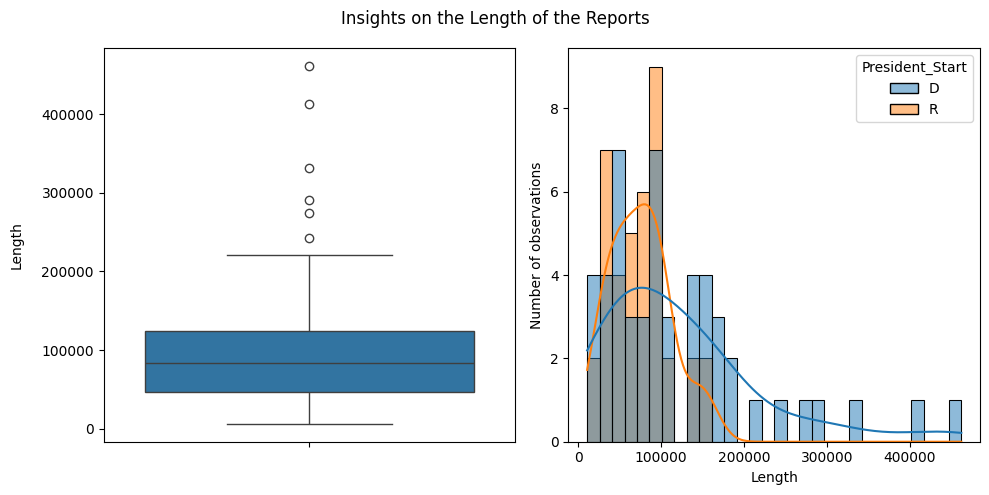

In [95]:
features_to_plot = df.columns.tolist()[-4:]
__ = visualize(features_to_plot[0], f'Insights on the {features_to_plot[0]} of the Reports')

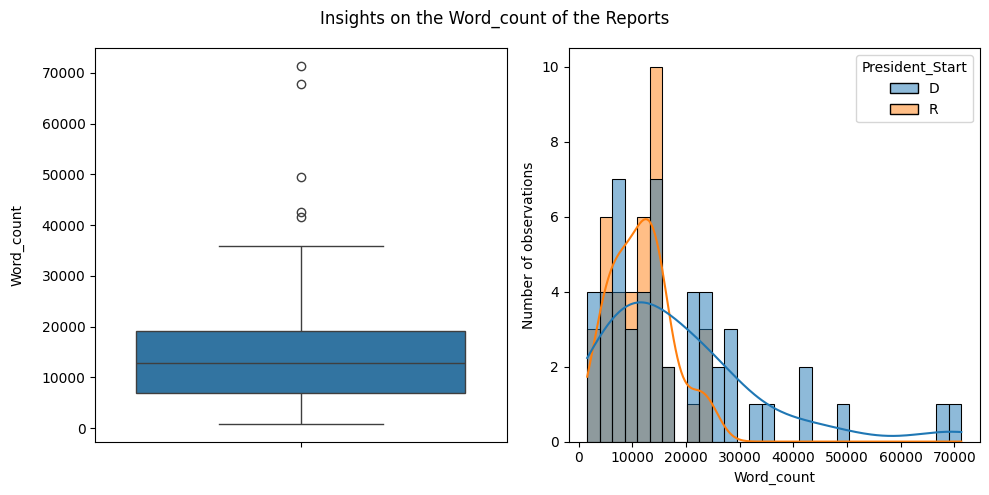

In [96]:
__ = visualize(features_to_plot[1], f'Insights on the {features_to_plot[1]} of the Reports')

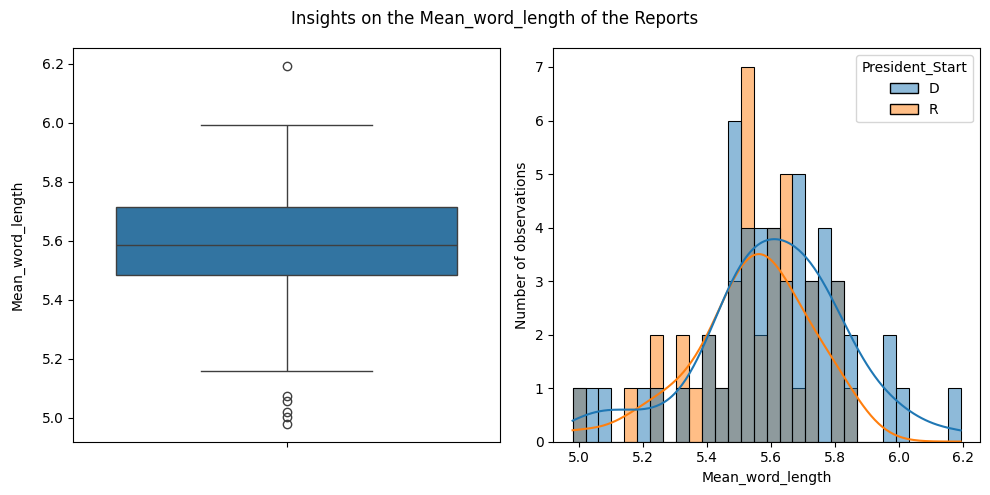

In [97]:
__ = visualize(features_to_plot[2], f'Insights on the {features_to_plot[2]} of the Reports')

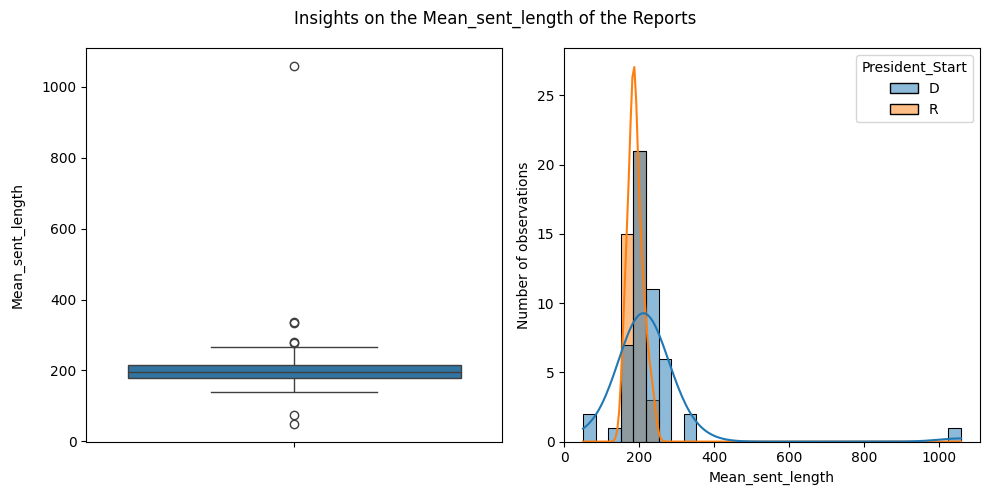

In [98]:
__ = visualize(features_to_plot[3], f'Insights on the {features_to_plot[3]} of the Reports')

We inspect the outlier within `Mean_sent_length` and find out that the outlier comes from a lack of punctuation for some reason.

_Question: Should we investigate further the original document to see if the lack of punctation comes form a preprocessing step?_

From these graphs we see that approximately 90% of the reports are under 200'000 characters and 95% are using less than 40'000 words. The reports are written in English and the mean word length revolves around 5.6 characters, which coincides with a general observation of 5.1 characters (see [this link](https://www.researchgate.net/figure/Average-word-length-in-the-English-language-Different-colours-indicate-the-results-for_fig1_230764201#:~:text=...,-•&text=Paragraph%20composition%3A%20each%20document%20is,is%205.1%20characters%20%5B6%5D%20)).

The difference in distribution is quite similar for `Mean_word_length`, but we can see that reports written under republican government use almost twice the number of words (see the distribution for `Length` and `Word_count`). We also see that the mean sentence length of these reports is four times larger than for reports written under democratic governments.



*Question: can we say democratic governments as opposite to republican governments ?*


#### Language detection

A rough pass at detecting languages is performed to observe if there are deviations from the main language of the reports, which is English. It takes a very long time to run langtedect over entire reports, so we focus on the two first sentences. From the results we see that our dataset is accurately written only in English (the minimum probability for a text being 0.999994).

_Question: should we perform only on the 2 first or maybe more ?_

In [100]:
# Function to select n first sentences from a text
def select_n_sentences(text:str, n:int=2):
  '''
    Returns the n first sentences of a text.

    Parameters:
        text: The string which is to be cropped.

    Returns:
        first_two_sentences:The string containing 2 sentences.
    '''
  sentences = re.split(r'(?<=[.!?]) +', text)
  first_two_sentences = ' '.join(sentences[:n])
  return first_two_sentences

In [101]:
# Function to detect the language of a text
def detect_language_with_langdetect(row):
    '''
    Returns a tuple specifying the most probable language and the percentage of
    likelihood for the 'Text' column in a DataFrame row.

    Parameters:
        row: A Series object representing a DataFrame row.

    Returns:
        a tuple with the most probable language and probability
    '''
    try:
        # we access the 'Text' column in the row
        line = row['Text']
        langs = detect_langs(line)
        for item in langs:
            # The first one returned is usually the
            # one with the highest probability
            return item.lang, item.prob
    except:
        return "err", 0.0



In [102]:
# we apply the function ROW-WISE and assign the result to new columns
df[['lang', 'proba']] = df.apply(detect_language_with_langdetect, axis=1, \
                                 result_type='expand')

#Inspecting the shape
print(df.shape)

(99, 47)


The language detection module obtains really high probabilities for the reports, the lowest being 0.999994.

In [103]:
# Investigating basic statistics
df.proba.describe()

count    99.000000
mean      0.999997
std       0.000001
min       0.999994
25%       0.999996
50%       0.999997
75%       0.999998
max       0.999999
Name: proba, dtype: float64

We detect only English for the different reports.

In [104]:
# Investigating basic statistics
df.lang.describe()

count     99
unique     1
top       en
freq      99
Name: lang, dtype: object

We see that the most probable language is English with the lowest probability being 0.999994. This result satisfies our hypothesis that our data is written in English, and thus that we can use a model which is pre-trained on English language.

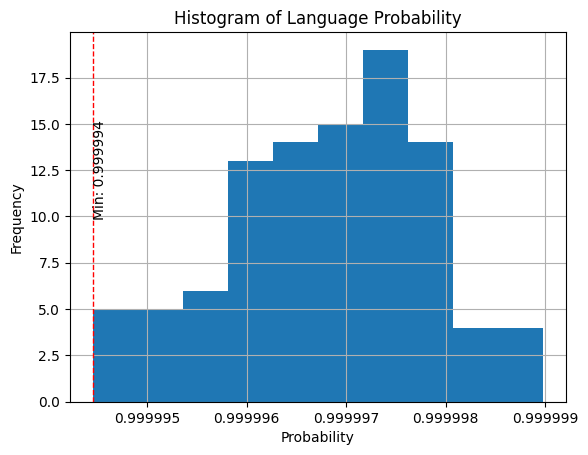

In [105]:
# Visualize the different language probability
ax = df['proba'].hist()

ax.ticklabel_format(useOffset=False, style='plain', axis='x')

ax.set_xlabel('Probability')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Language Probability')

# Find minimum value on the plot for reference
plt.axvline(df['proba'].min(), color='red', linestyle='dashed', linewidth=1)
plt.text(df['proba'].min(), ax.get_ylim()[1] * 0.5 , f'Min: {df.proba.min():.6f}', rotation=90)

plt.show()

_NB: We know that one of the report has a major part of its writting in Spanish and our method did not detect it since it is in the middle of the report. Should we select the 2 sentences in the middle of the report ?_

## Specific to our dataset

In this section we inquire the specificities of our dataset. Notably the presence and relation of the keywords within our report dataset.

It is important to note that we derived keywords that describe health-related topics from the USAID thesaurus. Keywords can be understood as representing the subjects, targets, and interventions of USAID activities. Examples of keywords are ‘health’, ‘HIV/AIDS’, and ‘bednets’. We derived our keywords from the thesaurus categories relevant to the health sector. Specifically, our keywords are taken from the section `health and safety` and the `family planning` sub-section within the `population and demography`section.


We classify our keywords as **politicized** (scored 3), **non-politicized** (1), or **potentially politicized** (2). Following Carlitz’s (2023) notion that the reproductive health sector is more politicized than other sectors, we classified such keywords as politicized. We classify keywords that are not related to reproductive health as non-politicized. Lastly, we classify keywords that capture interventions/targets that can be related to either reproductive or non-reproductive health as potentially politicized. Examples of keywords within the three categories are ‘condoms’, ‘eye diseases’, and ‘health education’. The classification was done by teaching assisstants with expertise in political science.

#### Keywords frequencies in reports

We start by verifying that each keyword is unique, which is indeed the case.

In [106]:
# Investigating the shape and values
print(f"Shape of the dataframe:{df_keywords.shape}")
print(f"Number of unique keywords:{df_keywords.Keyword.nunique()}")


Shape of the dataframe:(779, 2)
Number of unique keywords:779


First we need a few steps before vectorizing the texts to be able to use `CountVectorizer` from Sklearn.

In [107]:
# Function to perform basic cleaning steps to text data
def clean(text:str):
    '''
    Returns a string where we lowercased the text, and removed special
    characters and stopowords.

    Parameters:
        text: A string to clean.

    Returns:
        A lowecased text with special characters and stopwords removed.
    '''
    text = text.lower()
    text = re.sub('[^a-z A-Z 0-9-]+', '', text)
    text = " ".join([word for word in text.split() if word not in stopwords.words('english')])

    return text

In [108]:
# Applying the clean function to the text and keywords
# to standardize the strings
df['Text_clean'] = df['Text'].apply(clean)
df_keywords['Keyword_clean'] = df_keywords['Keyword'].apply(clean)

We see also that after cleaning, two keywords were actually identical. Our number of unique keywords is thus 778.

In [109]:
df_keywords['Keyword_clean'].nunique()

778

In [110]:
# Function to create a corpus of words from text data.
def corpus(text:str):
    '''
    Returns a list from all the words present in a certain string.

    Parameters:
        text: A text to tokenize.

    Returns:
        A list of words present in a text to create a corpus.
    '''
    text_list = text.split()
    return text_list

We apply the corpus function on all the texts.

In [111]:
df['Text_lists'] = df['Text'].apply(corpus)
df[['Text_clean','Text_lists']].head()

,Text_clean,Text_lists
0,jhnp2014ohanesian final progress report june 2...,"[jhnp2014ohanesian, final, progress, report, j..."
1,f n l r e p r 20092015 usaid tb program south ...,"[f, i, n, a, l, r, e, p, o, r, t, 20092015, th..."
2,1 usaidea flexible family planning reproductiv...,"[1, usaidea, flexible, family, planning,, repr..."
3,1 table contents letter director national aids...,"[1, table, of, contents, letter, from, the, di..."
4,zimbabwe final country report march 2007 publi...,"[zimbabwe, final, country, report, march, 2007..."


For a large number of keywords and texts, it's more efficient to use a vectorized approach that minimizes the number of scans through the texts. One common way to do this in Python is by using the `CountVectorizer` class from the scikit-learn library. This method will convert the text data into a matrix of token counts, which can then be used to count the occurrences of each keyword.

In [112]:
# We use CountVectorizer with ngrams between 1 and 3 terms
vectorizer = CountVectorizer(ngram_range=(1, 3), vocabulary=list(set(df_keywords.Keyword_clean.to_list())))

# We fit the vectorizer to the text data and transform the texts into a count matrix.
X = vectorizer.fit_transform(df['Text_clean'])

# We convert the result to a DataFrame with named columns (for readability)
df_ngram_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# We sum each column to get the total counts of each n-gram keyword
ngram_counts = df_ngram_counts.sum()

# ngram_counts is now a series with the counts of each n-gram keyword
print(ngram_counts)

burns                           1
blindness                       2
veterinary medicine             0
food processing standards       0
health innovations              0
                             ... 
disaster impact assessment      0
violence                      249
animal protein                  0
human diets                     0
spermicides                     5
Length: 778, dtype: int64


We see that half of the keywords are not used in any reports (450 words out of 778).

It is not a problem for us at the moment, but it could maybe a problem for the validation at the keyword level.

In [113]:
# Investigating the number of keywords not used
ngram_counts_data = pd.Series(ngram_counts)
print((ngram_counts_data==0).sum())

450


We create a dataframe containing the counts of each keywords(ngram) present within each report, representing a sparse matrix. We verify the shape of it which corresponds to the number of reports for the rows (99) and the number of keywords for the columns (778).

In [114]:
# Investigating the shape
df_ngram_counts.shape

(99, 778)

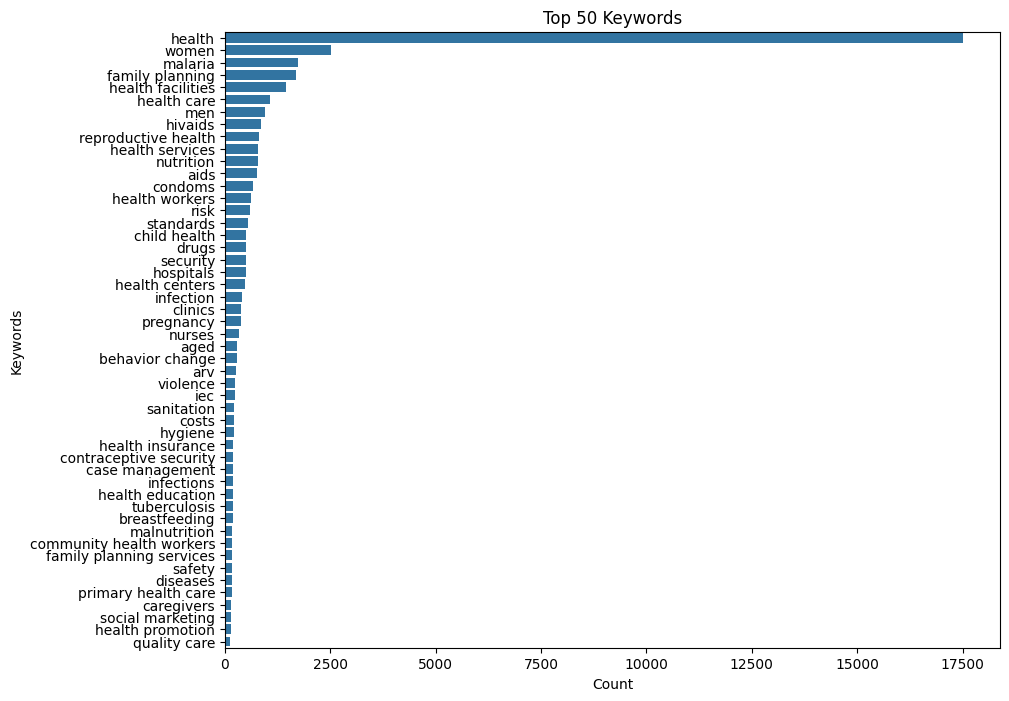

In [115]:
# Visualize the top 50 keywords used
top_n_df = ngram_counts.sort_values(ascending=False).head(50).reset_index()
top_n_df.columns = ['Keyword', 'Count']

# Horizontal bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Count', y='Keyword', data=top_n_df, orient='h')
plt.title('Top 50 Keywords')
plt.xlabel('Count')
plt.ylabel('Keywords')
plt.show()

We also want to check the number of reports which do not contain keywords, since politicization score will be generated using the keywords.

In [116]:
# We sum each row to get the total counts of keywords present per report.
report_keywords_counts = df_ngram_counts.sum(axis=1)

We see that the minimum number of keywords appearance for a report is 38 times. This satisfies our methodology of using keywords in order to generate a politicization score at the report level. Indeed, if a report did not contain any keywords, we would have had to exclude it from our corpus.

In [117]:
# Investigating the reports with the lowest number of keyword occurences
lowest_report_keywords_count = report_keywords_counts.sort_values(ascending=True).head(50)
lowest_report_keywords_count.describe()

count     50.000000
mean     218.600000
std       93.749993
min       38.000000
25%      153.750000
50%      227.500000
75%      295.500000
max      377.000000
dtype: float64

The following plot matches the index of the original datafram to the number of keyword appearance for the top 50 reports with lowest keywords count.

_NB: Here the y axis is the index, but it will be changed to match the Document ID of the reports._

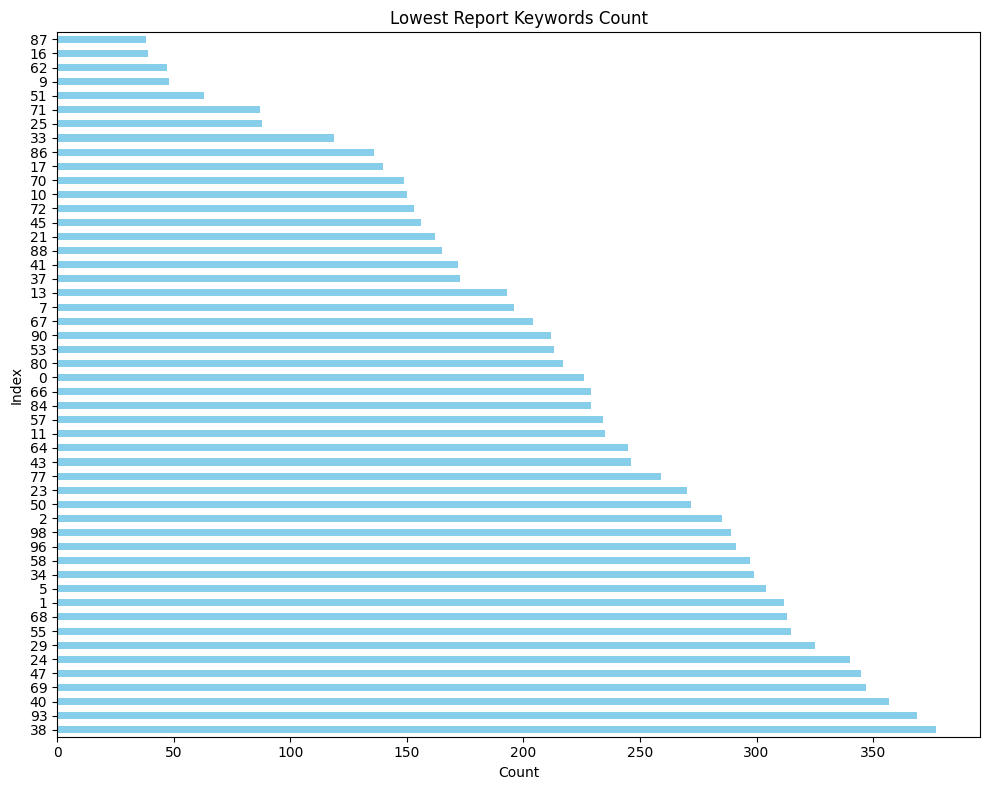

In [118]:
# Visualize the top 50 reports with the lowest number of keyword occurences
plt.figure(figsize=(10, 8))
lowest_report_keywords_count.plot(kind='barh', color='skyblue')
plt.xlabel('Count')
plt.ylabel('Index')
plt.title('Lowest Report Keywords Count')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

We plot a boxplot in order to determine the number of keyword appearance for our corpus and see that 95% of the reports are between 500 and 250 keyword appearances.

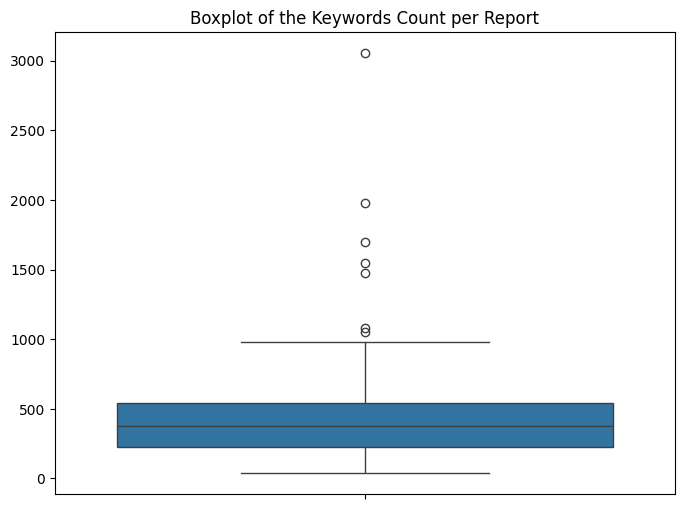

In [119]:
# Visualize keyword count as Box-PLot
plt.figure(figsize=(8, 6))
sns.boxplot(report_keywords_counts)
plt.title('Boxplot of the Keywords Count per Report')
plt.show()

#### Keywords frequencies for reports written under different parties

The following section focuses on comparing the keywords frequencies when we distinguish between reports evaluating interventions happenning under Republican or Democrat governments.

In [120]:
def get_top_n_keywords(dataframe:pd.DataFrame, n:int=50):
    '''
    Returns a Dataframe with the top n keywords present in the input dataframe
    as well as their count.

    Parameters:
        dataframe: A Dataframe containing a column 'Text_clean' to analyze.
        n: An integer, the top n number of keywords we want to identify.

    Returns:
        A df with the top n keywords and their count.
    '''
    vectorizer = CountVectorizer(ngram_range=(1, 3), vocabulary=list(set(df_keywords.Keyword_clean.to_list())))

    X = vectorizer.fit_transform(dataframe['Text_clean'])
    df_ngram_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    ngram_counts = df_ngram_counts.sum()
    df = ngram_counts.sort_values(ascending=False).head(n).reset_index()

    df.columns = ['Keyword', 'Count']

    return df

By plotting the top 50 most present keywords in the reports of both parties, we notice that the top 5 keywords under Democrats are about health, women, malaria, health facilities and family planning. Regarding the Republicans, the top 5 keywords are about health, family planning, women, men (interesting) and malaria.

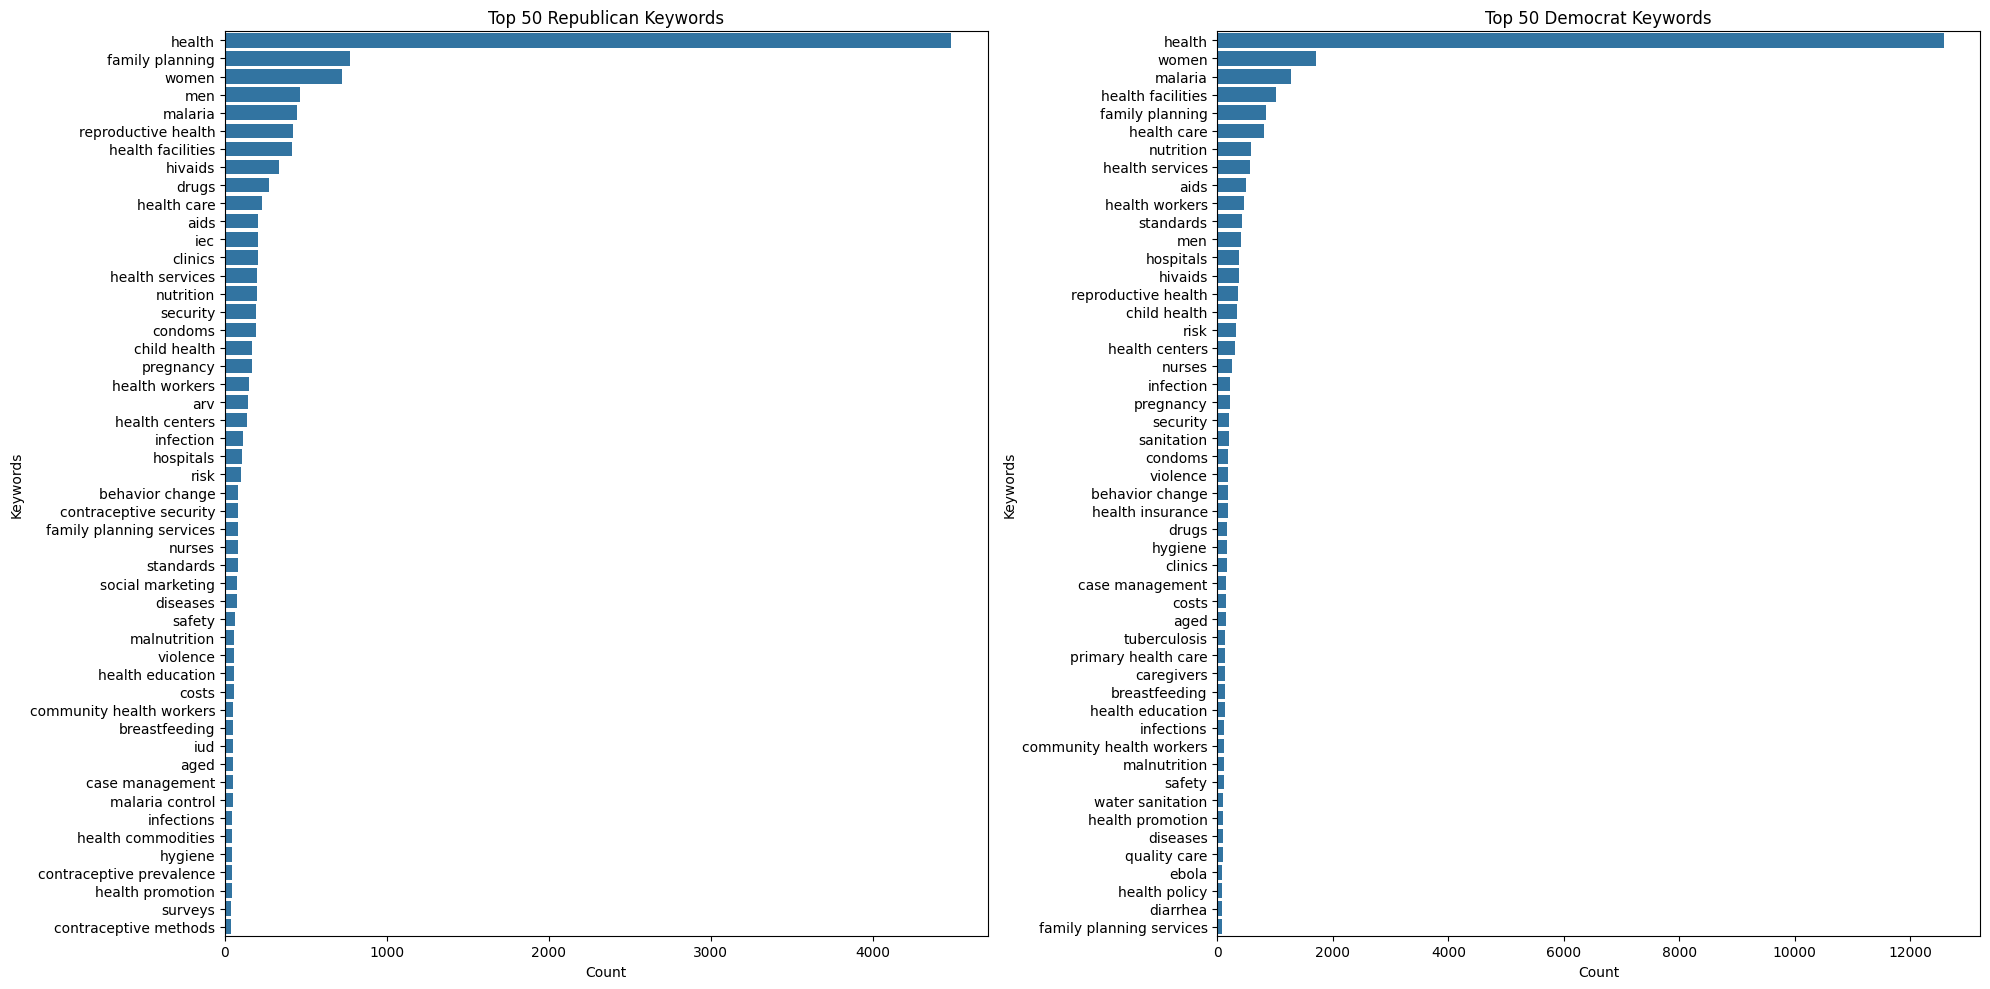

In [121]:
# Plotting the top 50 keywords of R and D in one figure to compare
top_r_keywords = get_top_n_keywords(df[df['President_Start'] == 'R'])
top_d_keywords = get_top_n_keywords(df[df['President_Start'] == 'D'])

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# We plot the Republicans reports
sns.barplot(x='Count', y='Keyword', data=top_r_keywords, orient='h', ax=axs[0])
axs[0].set_title('Top 50 Republican Keywords')
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Keywords')

# We plot the Democrats reports
sns.barplot(x='Count', y='Keyword', data=top_d_keywords, orient='h', ax=axs[1])
axs[1].set_title('Top 50 Democrat Keywords')
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Keywords')

plt.tight_layout()
plt.show()

We now want to have compare the top 50 common words for both parties. We remove the keyword `health` since its broad usage makes it difficult to visualize the other keywords. We see that in general

In [122]:
# We rename the `Count` columns of both dataframes
top_r_keywords = top_r_keywords.rename(columns={
    'Count': 'Count_r'
})
top_d_keywords = top_d_keywords.rename(columns={
    'Count': 'Count_d'
})

We notice that in most of the cases, reports evaluating interventions under Democrat government use more Thesaurus keywords.

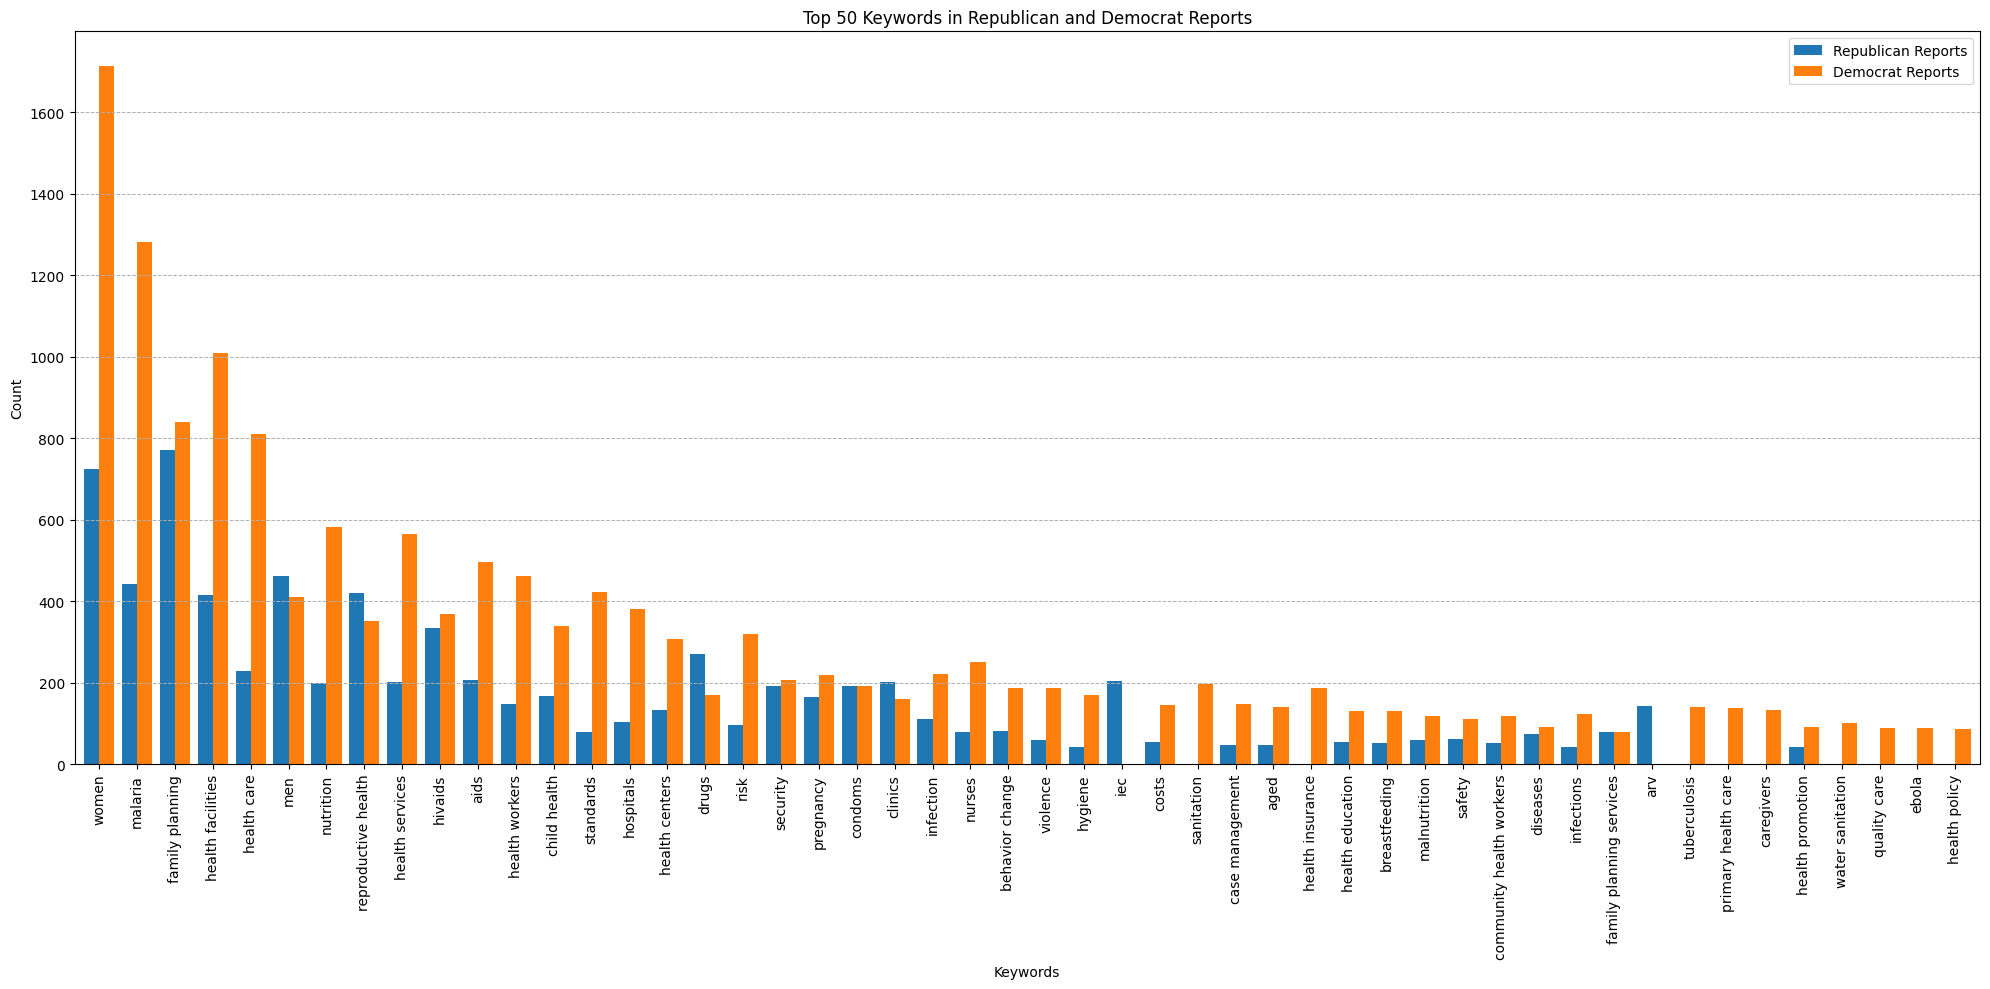

In [124]:
# Merge the two DataFrames on the keywords to have side by side comparison
# (if a keyword isn't in the top 50 for one party, its count will be NaN
# which we will replace with zero)
combined_keywords = pd.merge(top_r_keywords, top_d_keywords, \
                             on='Keyword', how='outer').fillna(0)
combined_keywords.set_index('Keyword', inplace=True)

# We sort the keywords (on the sum of both counts to get the most common overall)
combined_keywords['Total_Count'] = \
 combined_keywords['Count_r'] + combined_keywords['Count_d']
combined_keywords.sort_values('Total_Count', ascending=False, inplace=True)
combined_keywords.drop('Total_Count', axis=1, inplace=True)

# We select the top 50 and remove the first one which is `health`
combined_keywords = combined_keywords.iloc[1:51]

# We plot
ax = combined_keywords.plot(kind='bar', figsize=(20, 10), width=0.8)
plt.title('Top 50 Keywords in Republican and Democrat Reports')
plt.xlabel('Keywords')
plt.ylabel('Count')

# Readability
plt.xticks(rotation=90)
plt.legend(['Republican Reports', 'Democrat Reports'])
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()


#### Keywords politicization score

In this section we examine the different politicization scores.

In [125]:
# Investication head()
df_keywords.head()

,Keyword,POLITICISED,Keyword_clean
0,Cancers,1,cancers
1,Immunologic diseases,1,immunologic diseases
2,Allergies,1,allergies
3,Food allergies,1,food allergies
4,Deficiency diseases,1,deficiency diseases


We see that all keywords have a politicization but the classes are imbalanced with a large number attributed a 1, meaning non-politicized. This is not an issue for our model as we are not training data but using a pre-trained model.

In [126]:
# Investigate the different politicization score
df_keywords['POLITICISED'].value_counts(dropna=False)

POLITICISED
1    610
3    112
2     57
Name: count, dtype: int64

We then have a look at the different categories. Here is an explanation about the grading:

- 1: Non-Politicized
- 2: Potentially Politicized
- 3: Politicized

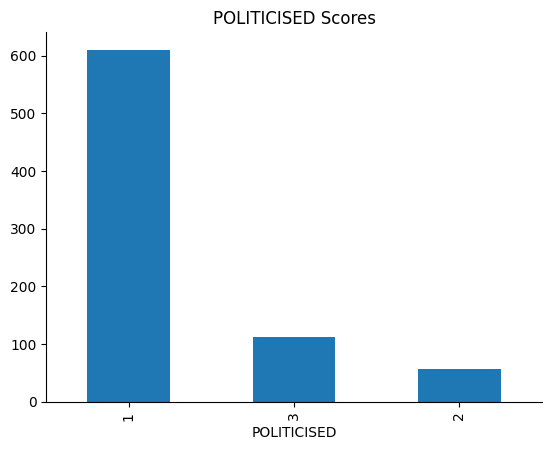

In [127]:
# Visualization of the different politicited scores
df_keywords['POLITICISED'] = df_keywords['POLITICISED'].astype(str).\
replace('nan', 'Unknown')

category_counts = df_keywords['POLITICISED'].value_counts()

category_counts.plot(kind='bar', title='POLITICISED Scores')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Most of the keywords are considered non-politicized, meaning they are not related to the reproductive health sector. This makes sense since the keywords we use were retrieved from the broader section ‘health and safety’ and the
‘family planning’ sub-section within the ‘population
and demography’ section of Thesaurus keywords.

## Metadata

The following metadata was partly gathered from the DEC office and party manually added by the student assistants experts in political science (metadata on the governments, as well as notes).

### Corpus of reports

Here we have a look into a few metadata of the reports to have an idea of the general context of our corpus, namely the timespan and the interventions' location.

#### Timespan

We visualize the publication dates of the USAID evaluation reports thanks to an histogram. Our reports span from 2003 to 2021, the two busiest year being 1007 and 2019 (which were campaign years for president elections). It is also interesting to see that 2004, 2011 and 2012 did not produce any reports under our labels, despite being campaign years as well.

There does not seem to be a trend regarding the publication of reports. These reports might be part of political agenda for campaign years, but it is not always the case and might depend from the strategy of the president in action at the time.

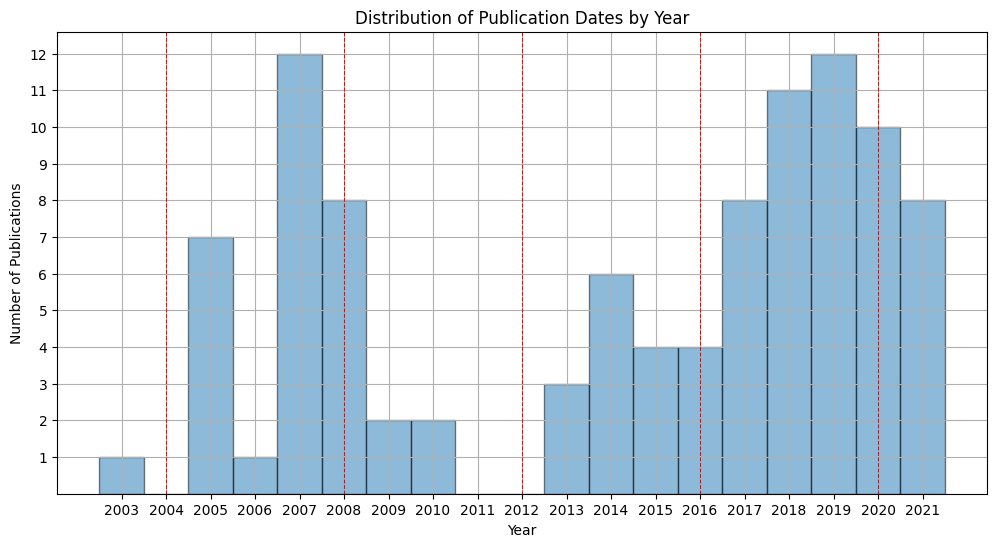

In [181]:
# Visualization of the Publication years as histogram
plt.figure(figsize=(12, 6))

# election years
election_years = range(2004, df['Publication Date'].max() + 1, 4)
for year in election_years:
    plt.axvline(x=year, color='red', linestyle='dashed', linewidth=0.75, \
                label='Election Year' if year == 2004 else "")

# publication years
year_bins = np.arange(df['Publication Date'].min() - 0.5,\
     df['Publication Date'].max() + 1.5, 1)
df['Publication Date'].hist(bins=year_bins, alpha=0.5, edgecolor='black')

plt.title('Distribution of Publication Dates by Year')
plt.xlabel('Year')
plt.ylabel('Number of Publications')

# x-ticks to be the middle of each bin
plt.xticks(range(df['Publication Date'].min(), df['Publication Date'].max() + 1))

# + 1 for padding.
plt.yticks(range(1, int(df['Publication Date'].value_counts().max()) + 1))

plt.show()

#### Region of interventions

We see and confirm that most of the interventions take place in Africa, with the exception of a few reports in South America.

<ipython-input-131-903ec7979581>:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


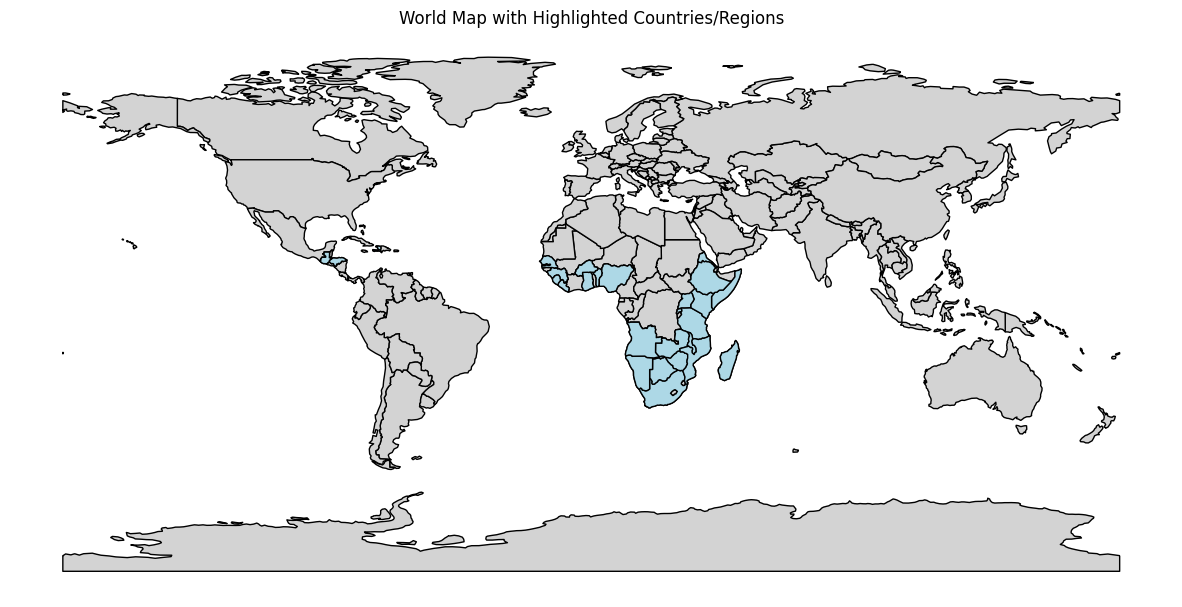

In [131]:
# Creating a map of the reports' regions

# We plot the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

ax = world.plot(color='lightgray', edgecolor='black', figsize=(15, 13))

# We then highlight the countries of the reports
reports_countries = world[world['name'].isin(df['Country/Region Name'].unique())]
reports_countries.plot(ax=ax, color='lightblue', edgecolor='black')

ax.set_title('World Map with Highlighted Countries/Regions')
ax.set_axis_off()

plt.show()

### Missing values

In this section we check the missing values of the dataframe related to the metadata of the reports as well as `dtypes`.

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Document ID                 99 non-null     object 
 1   Text                        99 non-null     object 
 2   Document Type               99 non-null     object 
 3   Authoring Organization(s)   98 non-null     object 
 4   Sponsoring Organization(s)  98 non-null     object 
 5   Pagination                  99 non-null     int64  
 6   Contract/Grant Number(s)    99 non-null     object 
 7   Country/Region Name         99 non-null     object 
 8   Publication Date            99 non-null     int64  
 9   Year Start                  99 non-null     object 
 10  Year End                    99 non-null     object 
 11  President_Start             90 non-null     object 
 12  Senate_Start                90 non-null     object 
 13  House_Start                 90 non-nu

We have a look at the columns with missing values. Since we need to divide the reports between Democratic and Republican, we are interested in the columns related to politics. The most important columns are `Year Start` and `Year End`. We see that `Year Start` determines 4 other columns and `Year End`determines 16 other columns.

12 reports are affected by missing values of `Year End` column which is quite significant for our dataset of 99 reports.

The missing values regarding `Authoring Organization(s)`, `Sponsoring Organization(s)`, `Month Start`, `Month End`, `Tags` and `Notes` are not relevant since we will not be using them in the future.

In [133]:
missing_values_count = df.isnull().sum()
print(missing_values_count[missing_values_count > 0])

Authoring Organization(s)      1
Sponsoring Organization(s)     1
President_Start                9
Senate_Start                   9
House_Start                    9
PSH_Start                      9
DivGov_Start                   9
President_End                 12
Senate_End                    12
House_End                     12
PSH_End                       12
DivGov_End                    12
Project_Duration              12
DivGov_ProjectYears           12
DivGov_FractionProject        12
DemPres_ProjectYears          12
DemPres_FractionProject       12
DemSen_ProjectYears           12
DemSen_FractionProject        12
DemHouse_ProjectYears         12
DemHouse_ProjectFraction      12
DivGov_MajorityProject        12
DemPres_MajorityProject       12
Month Start                   33
Month End                     33
Tags                          10
Notes                         78
dtype: int64


We also notice that the columns `Year Start` and `Year End` have sometimes the value '?'. Thus we remove it in order to have a good idea of the missing values.

In [134]:
df = df.replace('?', np.nan)

In [135]:
filtered_rows = df[df['Document ID'].isin(['PDACG819', 'PA00Z4ZW', 'PDACL854'])]
print(filtered_rows[['Year Start', 'Year End']])

   Year Start Year End
67        NaN      NaN
82      2003?    2005?
88      2020?    2021?


In [136]:
columns_to_correct = ['Year Start', 'Year End']
for col in columns_to_correct:
    # change '?' with '', and then attempt to convert to numeric,
    # we coerce errors to NaN (for missing data)
    df[col] = df[col].apply(lambda x: x.replace('?', '') if isinstance(x, str) else x)
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

    #df[col] = df[col].astype('Int64')

In [137]:
filtered_rows = df[df['Document ID'].isin(['PDACG819', 'PA00Z4ZW', 'PDACL854'])]
print(filtered_rows[['Year Start', 'Year End']])

    Year Start  Year End
67        <NA>      <NA>
82        2003      2005
88        2020      2021


In [138]:
missing_values_count = df.isnull().sum()
print(missing_values_count[missing_values_count > 0])

Authoring Organization(s)      1
Sponsoring Organization(s)     1
Year Start                     9
Year End                      12
President_Start                9
Senate_Start                   9
House_Start                    9
PSH_Start                      9
DivGov_Start                   9
President_End                 12
Senate_End                    12
House_End                     12
PSH_End                       12
DivGov_End                    12
Project_Duration              12
DivGov_ProjectYears           12
DivGov_FractionProject        12
DemPres_ProjectYears          12
DemPres_FractionProject       12
DemSen_ProjectYears           12
DemSen_FractionProject        12
DemHouse_ProjectYears         12
DemHouse_ProjectFraction      12
DivGov_MajorityProject        12
DemPres_MajorityProject       12
Month Start                   33
Month End                     33
Tags                          10
Notes                         78
dtype: int64


The following columns are missing information related to the goverments. These columns are important to determine under which category does a report fall (between Democrat and Republican).

Related to the beginning of the intervention:
- Year Start
- President_Start    
- Senate_Start      
- House_Start      
- PSH_Start   
- DivGov_Start

Related to the end of the intervention:
- Year End
- President_End            
- Senate_End                   
- House_End                  
- PSH_End                   
- DivGov_End

Related to both:
- Project_Duration              
- DivGov_ProjectYears           
- DivGov_FractionProject
- DemPres_ProjectYears         
- DemPres_FractionProject       
- DemSen_ProjectYear     
- DemSen_FractionProject       
- DemHouse_ProjectYears        
- DemHouse_ProjectFraction
- DivGov_MajorityProject         
- DemPres_MajorityProject

The rest of the columns were completed accordingly to the information available in the reports. Since these reports are conducted by different independent agency, there is no real stadard on how to fill them.

We will not be using this information anyway.

### Filling missing values

We know that the columns related to the government information are filled according to the columns `Year Start` and `Year End`. Some reports are missing this crucial information. For this reason it is important to find a way to replace these missing values. We decide to use the other temporal column we have, which is the year the evaluation report was published (`Publication Date`). It is a good indicator since it is logically always written after an intervation took place.

We check on average how many years after the end of a project the evaluation report is published. It seems it is usually published the same year an intervention ends. For this reason we fill the `Year End` column with the value from `Publication Date`.



In [139]:
# Visualization of difference between Year End and Publication Date
df['Date Difference'] = (df['Publication Date'] - df['Year End'] )
print(df['Date Difference'].describe())
print(df['Date Difference'].unique())


count        87.0
mean     0.310345
std      0.556366
min          -2.0
25%           0.0
50%           0.0
75%           1.0
max           2.0
Name: Date Difference, dtype: Float64
<IntegerArray>
[0, 1, <NA>, 2, -2]
Length: 5, dtype: Int64


We check which row corresponds to a negative difference, and it seems one report was written the same year it started and 2 years before it ended. Since it is only one report we will not handle this case.

_Do we have more information about this ?_

In [140]:
df.loc[df['Date Difference'] == df['Date Difference'].min()]\
 [['Publication Date','Year Start', 'Year End']]

,Publication Date,Year Start,Year End
62,2005,2005,2007


In [141]:
# Filling missing values from `Year End` with `Publication Date` values
df['Year End'] = df['Year End'].fillna(df['Publication Date'])

# Replace missing values in 'Year Start' with values from 'Publication Date', if needed
df['Year Start'] = df['Year Start'].fillna(df['Publication Date'])

In [142]:
# Function to fill missing values of target columns
def fill_missing_values(df:pd.DataFrame, year_column:int, target_columns:list):
    '''
    Fills the missing values from the columns contained in target_colums based
    on the year_column value. The idea is that if we do not have these values,
    we'll take the information of another report which has the same year_column.
    This make sense since the information we are interested in are about
    governments and thus are the same for similar year (e.g. the president,
    senate and house of congress are the same in 2007, we do not take election
    years into account).
    Returns the filled df.

    Parameters:
        df: The dataframe of interest containing year_column and target_columns.
        year_column: The name of the column from which we fill the values of the
        target_columns.
        target_columns: A list containing the names of the columns to
        fill as str.

    Returns:
        The same df but with filled values for the target_columns.
    '''
    for index, row in df.iterrows():
        # we identify missing values
        missing_cols = [col for col in target_columns if pd.isnull(row[col])]

        if missing_cols:
            fill_row = df[(df[year_column] == row[year_column]) & df[missing_cols].notnull().all(axis=1)]

            if not fill_row.empty:
                for col in missing_cols:
                    df.at[index, col] = fill_row[col].values[0]

In [146]:
# We apply the function to our dataset two times
# the first time for the columns related to 'Year Start'
# the second time for the columns related to 'Year End'
start_columns = ['President_Start', 'Senate_Start', 'House_Start', \
                 'PSH_Start', 'DivGov_Start']
end_columns = ['President_End', 'Senate_End', 'House_End', \
               'PSH_End', 'DivGov_End']

fill_missing_values(df, 'Year Start', start_columns)
fill_missing_values(df, 'Year End', end_columns)


Here we simply have a look at a few lines. The report PA00KM9H was missing informatio regarding `Year Start` and `Year End` and is now filled correctly.

In [144]:
df[['Document ID','Publication Date','Year Start', \
    'Year End', 'President_Start', 'Senate_Start', 'House_Start']].tail()

,Document ID,Publication Date,Year Start,Year End,President_Start,Senate_Start,House_Start
94,PA00XKDW,2021,2017,2021,R,R,R
95,PA00K9TJ,2014,2010,2014,D,D,D
96,PA00ZDZP,2020,2019,2020,R,R,D
97,PA00MGHW,2016,2011,2016,D,D,R
98,PA00KM9H,2007,2007,2007,R,D,D


In [148]:
missing_values_count = df.isnull().sum()
print(missing_values_count[missing_values_count > 0])

Authoring Organization(s)      1
Sponsoring Organization(s)     1
Project_Duration              12
DivGov_ProjectYears           12
DivGov_FractionProject        12
DemPres_ProjectYears          12
DemPres_FractionProject       12
DemSen_ProjectYears           12
DemSen_FractionProject        12
DemHouse_ProjectYears         12
DemHouse_ProjectFraction      12
DivGov_MajorityProject        12
DemPres_MajorityProject       12
Month Start                   33
Month End                     33
Tags                          10
Notes                         78
Date Difference               12
dtype: int64


### Different governments

In this section we check if the reports we are using can be differentiated in two balanced categories as Republican and Democratic interventions. We are interested in this since in the methodology we want to generate and compare keyword embeddings under these two political poles.

In [149]:
df.President_Start.values

array(['D', 'D', 'R', 'D', 'R', 'R', 'D', 'R', 'D', 'D', 'D', 'D', 'R',
       'D', 'R', 'D', 'R', 'D', 'R', 'D', 'D', 'D', 'D', 'D', 'D', 'R',
       'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D',
       'D', 'D', 'R', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'R', 'R', 'D',
       'R', 'D', 'D', 'R', 'R', 'R', 'R', 'D', 'R', 'D', 'R', 'D', 'R',
       'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R',
       'R', 'D', 'R', 'R', 'R', 'R', 'R', 'D', 'R', 'D', 'R', 'D', 'R',
       'D', 'R', 'D', 'R', 'D', 'R', 'D', 'R'], dtype=object)

We see that the reports are written under quite imbalanced goverments. This is the case when we use the variable `President_Start` to determine under which goverment an intervetion took place. This is a naive approach which we will change in the future (we will use a variable that determines under which government the intervention took place the **majority of the time**, thus this section might change).

In any case this result does not impact significantly our methodology as we do not train a model on our data but rather use a pre-trained contextualized embedding model.

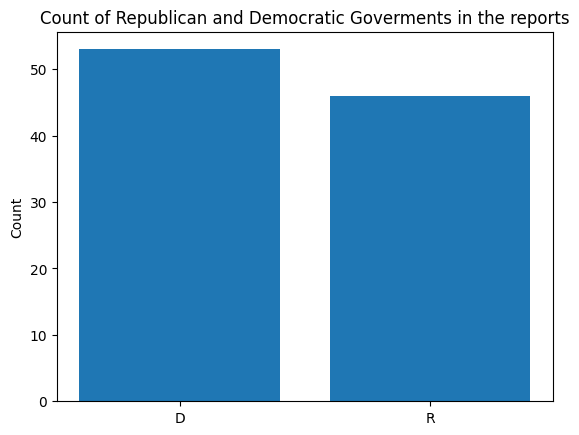

In [150]:
counts = df['President_Start'].value_counts()
plt.bar(counts.index, counts.values)
plt.title('Count of Republican and Democratic Goverments in the reports')
plt.ylabel('Count')
plt.show()

In [151]:
# Inspecting the value counts
print(counts)

President_Start
D    53
R    46
Name: count, dtype: int64


We also see that more than half of the projects were conducted under different governments for the majority of the project time.

In [152]:
# Inspecting the value counts
df.DivGov_MajorityProject.value_counts()

DivGov_MajorityProject
1.0    47
0.0    40
Name: count, dtype: int64

### Distinguishing between governments

Until now we determined the government under which an intervention was conducted solely on the party of the president at the start of an intervention. The reason was that it made sense that USAID interventions would be aligned with political agenda of the president, and it was a simplification that saved us some complications. Nevetheless it might be too simple and therefore we want to determine a better way to determine this.

Evaluation reports asses interventions which usually spans over a few years. For this reason, the party an intervention was initally planned and conducted under can change. In order to determine whether a report is labeled as Democrat or Republican, we need to come up with a method.

A nice way to do this would be to find under which party the intervention was conducted the majority of the time.




Algorithm:

For reports which have values about the democratic fraction of the three institutions (`DemPres_FractionProject`, `DemSen_FractionProject`, `DemHouse_ProjectFraction`):
 we decide to determine that a project was conducted under Democrat government if 2 of these fractions are larger than 50% (this is a choice and should be discussed in the future).

If we do not have value for the democratic fractions of the time: we resolve to count the number of institutions of each party at the end and at the beginning of the interventions. The one with the largest number is attributed as the `Government` value (again this a choice and can be changed in the future).


In [153]:
# Function to classify reports under a certain government
# rule based, could be changed easily
def classify_government(row, target_columns:list = \
 ['President_Start', 'Senate_Start', 'House_Start',\
  'President_End', 'Senate_End', 'House_End']):
    '''
    Fills a row with either the value 'D' or 'R' to determine under which
    government a project was conducted the majority of the time. It takes
    two cases into account: whether we have access to information regarding
    Democrat fraction of the project or if we do not, in which case we compare
    the number institutions for each party at the begging and at the end of
    an intervention.

    Parameters:
        row: A row corresponding to a report.
        target_columns: A list of column names containing the party of
        the three institutions at the start and end of an intervention.

    Returns:
        A str value (either 'D' for Democrat or 'R' for Republican).
    '''
    # if we missed information about the fractions of the project
    if pd.isnull(row['DemPres_FractionProject']) or \
    pd.isnull(row['DemSen_FractionProject']) or \
     pd.isnull(row['DemHouse_ProjectFraction']):
        counts = {
            'D': sum(row[col] == 'D' for col in target_columns),
            'R': sum(row[col] == 'R' for col in target_columns)
        }
        return 'D' if counts['D'] > counts['R'] else 'R'
    # if fractions are available
    else:
        conditions_met = sum([
            row['DemPres_FractionProject'] > 0.5,
            row['DemSen_FractionProject'] > 0.5,
            row['DemHouse_ProjectFraction'] > 0.5
        ])
        return 'D' if conditions_met >= 2 else 'R'

In [154]:
# Apply to each row of our dataframe
df['Government'] = df.apply(classify_government, axis=1)

We notice that there are twice the number of Republican reports compared to the ones of Democrat. This imbalance shouldn't impact the contextual embeddings methodology since we are not training a model with imabalanced data. Still, it could impact our results since the Republican reports are over-represented, leading to their embeddings being more refined.

This is an issue to discuss further. A potential solution would be to determine differently to what government a report belongs.

In [155]:
# Inspecting the number of each value
df['Government'].value_counts()

Government
R    69
D    30
Name: count, dtype: int64